In [2]:
# load packages

# core quantitative analysis packages
import numpy as np
import pandas as pd

# visualisation
import matplotlib.pyplot as plt # default package
%matplotlib inline

# machine learning
#  models ordered in order of usage in the worksheet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
import xgboost # you will need to install this package, see code below to install

In [ ]:
# to install a package you don't have installed (remove the hashtags below to run)

# import sys
# !{sys.executable} -m pip install xgboost

## Part 1: Preparing the dataset

In [4]:
# load the dataset (available from Moodle, need to load the data into Google Colab, see last class)

housing = pd.read_csv("Class2_3_data.csv")

In [5]:
# inspect the data

# 1. run the .head() command to see the general format of the data

housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [6]:
# inspect the data

# 2. run the .info() command to check size of dataset and if any missing data

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
# inspect the data

# 3. run the .describe() command to get summary statistics

housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

Note on the data:

This is a dataset of districts of California and the housing characteristics of each district. We have the longitude and latitude of the location of the district, we have the average house age in the district, the median house price, the population of the district and the number of households that comprises. We know the total number of rooms per district as well as a subset of the total number of bedrooms. 

The median income looks strange - this is because it has been scaled. For the purposes of this analysis (and reasonably accurately) you can assume that median income is expressed in 10s of thousands. So a median value of 3.87 represents $38,700. 

Note also that there is a non-numerical column: ocean_proximity. This is likely to be an important value determinant given the excellent climate of California, so high value will surely be attached to being near the sea. We'll need to convert this variable into a quantitative variable for our analysis.

In [8]:
# check the ocean_proximity variable

housing['ocean_proximity'].value_counts()

# note the very low values for 'island' - we might want to merge this into another category in future analysis

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

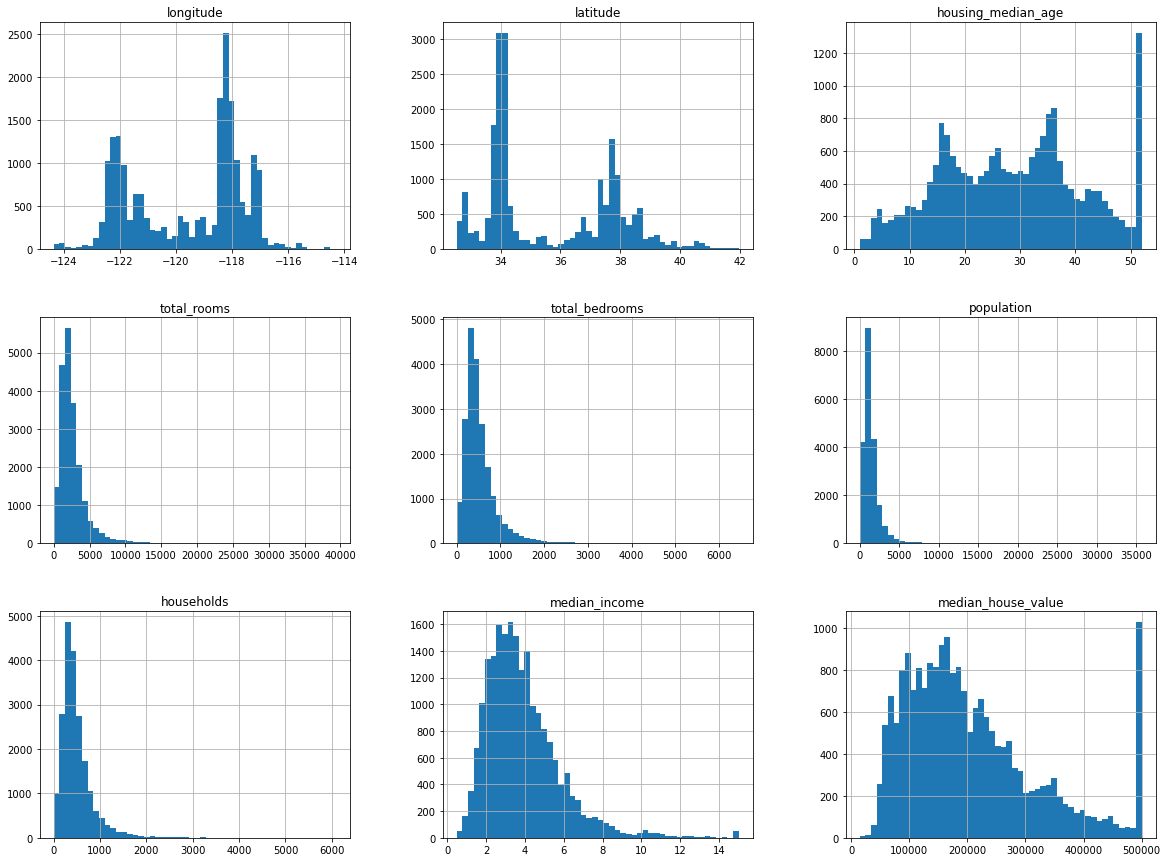

In [10]:
# visually inspect the data

housing.hist(bins=50, figsize=(20,15))
plt.show()

Notes on this:

The variables median_house_value and housing_median_age are clearly capped. We need to be aware of this in our testing. Practically speaking, our model might predict a house value over $500,000 (the cap level) and be judged as inaccurate, when really its because the dataset itself was capped. 

Some other data features: (1) theres a long tail to quite a few of the variables, (2) they are at very different scales, and (3) the variables sometimes lack a bell-curve style distribution (e.g. housing_median_age) which works best for linear regression models.

In [11]:
# creating a training and testing dataset

# in the first class we generated a random split between training and testing
# this is normally fine *if a random sample is likely to well-represent your overall sample*

# first create an income_cat variable so we can inspect the sample distributions
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

# then train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


# inspect the split
print(train_set['income_cat'].value_counts() / len(train_set))
print(test_set['income_cat'].value_counts() / len(test_set))

3    0.348595
2    0.317466
4    0.178537
5    0.115673
1    0.039729
Name: income_cat, dtype: float64
3    0.358527
2    0.324370
4    0.167393
5    0.109496
1    0.040213
Name: income_cat, dtype: float64


In [12]:
# a better train and test set split: stratified splits

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
# inspect the split
print(strat_train_set['income_cat'].value_counts() / len(strat_train_set))
print(strat_test_set['income_cat'].value_counts() / len(strat_test_set))

# although note that you need to choose the 'right' variable to split on

# we'll now remove the income_cat variable as we don't need it anymore
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64


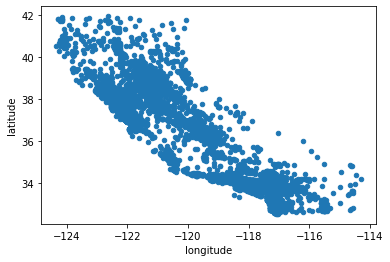

In [14]:
# further visualisation

# first, turn the training dataset into the main housing dataset, as we shouldn't be looking at the test dataset
housing = strat_train_set.copy()

# let's look at the geography of our dataset
housing.plot(kind='scatter', x='longitude', y='latitude')
plt.show()

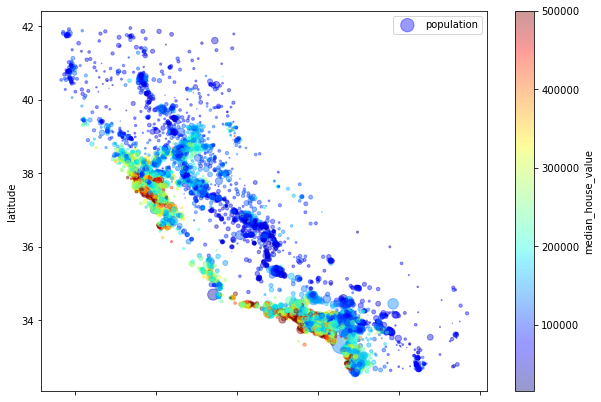

In [16]:
# improved geographical inspection: weighting by population

housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population', figsize=(10,7),
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.show()

In [17]:
# check correlations to get a basic idea of relationships

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

In [18]:
# are there any new variables we can create here?

housing['rooms_per_household'] = housing['total_rooms'] / housing ['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [19]:
# we now have a decent idea of the basic relationships in our data
# let's start the formal analysis by creating a clean copy of our housing training dataset
# we'll add back in some expected relationships at a later stage

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

Note: here, I am going to manually show the individual steps needed, later in the analysis I will demonstrate how to combine these steps in a near-automated way. The combination stage is important, as it allows us to quickly transform future datasets in the same way. 

In [20]:
# first, note the missing data for total_bedrooms

housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [21]:
# 1. Handling missing data

# ideally we don't want to lose those rows of data, so we will 'impute' estimates for missing values

# set up the imputer - we normally go with a median strategy absent good information to the contrary
imputer = SimpleImputer(strategy='median')

# we need to temporarily drop ocean_proximity as it is not a numerical value
housing_num = housing.drop('ocean_proximity', axis=1)

# even though total_bedrooms is the only column with missing values, we will calculate imputed values for all columns
# this future-proofs our code in case future data has missing values for other columns
imputer.fit(housing_num)
imputer.statistics_
housing_num.median().values
print(housing_num.median().values) # check
X = imputer.transform(housing_num) # creates a matrix with all missing values transformed to imputed values
housing_tr = pd.DataFrame(X, columns=housing_num.columns, 
                          index=housing_num.index) # transforms matrix back to a dataframe

# check it has worked
housing_tr.info()

[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [22]:
# 2. Handling text data in the form of categories

# first, we'll make a series of the ocean_proximity data to see how to transform it
housing_cat = housing[['ocean_proximity']]
print(housing_cat['ocean_proximity'].unique())
print(housing_cat.head(10))

['INLAND' 'NEAR OCEAN' '<1H OCEAN' 'NEAR BAY' 'ISLAND']
      ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN
1481         NEAR BAY
18125       <1H OCEAN
5830        <1H OCEAN
17989       <1H OCEAN
4861        <1H OCEAN


In [23]:
# we will use OneHotEncoder to turn this data into dummy category variables

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [24]:
cat_encoder.categories_

# look back to the housing_cat.head() output to confirm that coding makes sense

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [25]:
# 3. Scaling datasets
# Machine learning algorithms work best when all variables are on the same scale
# We can use the sklearn StandardScaler for this

scale = StandardScaler()
housing_scale = scale.fit_transform(housing_num)
# we use housing_num for this example as it excludes ocean_proximity, a text variable which can't be scaled
housing_sc = pd.DataFrame(housing_scale, columns=housing_num.columns, 
                          index=housing_num.index) # transforms matrix back to a dataframe

housing_sc.describe().round(2) # check it works .describe()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
count   16512.00  16512.00            16512.00     16512.00        16354.00   
mean       -0.00      0.00                0.00        -0.00            0.00   
std         1.00      1.00                1.00         1.00            1.00   
min        -2.39     -1.45               -2.20        -1.22           -1.29   
25%        -1.11     -0.79               -0.85        -0.55           -0.58   
50%         0.53     -0.65                0.03        -0.24           -0.25   
75%         0.78      0.97                0.66         0.24            0.26   
max         2.63      2.95                1.86        17.16           13.75   

       population  households  median_income  
count    16512.00    16512.00       16512.00  
mean         0.00       -0.00           0.00  
std          1.00        1.00           1.00  
min         -1.27       -1.32          -1.77  
25%         -0.57       -0.58          -0.69  
50%         -0.23       -0.24          -0.18  
75%          0.27        0.28           0.46  
max         30.71       12.94           5.84

In [26]:
# 4. Transformers to semi-automate workflow
# Transformers are codes that allow you to quickly transform data 
# The idea here is that you build up a collection of these over time and then can easily apply them to new datasets

# this bit is confusing. But we need to first set up some 'classes' called fit() and transform()

rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                       bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)


In [27]:
# 5. Combine all steps together in a pipeline
# Pipelines help us ensure we are working on data transformation in the right sequential steps
# Our steps are: (1) Impute missing data, (2) Add new attributes, (3) Scale the data, (4) Transform the category text data

# Step 5.1. Divide data into numerical and text columns

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

# Step 5.2. Set up all numerical transformations

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

# Step 5.3. Add together number and text transformations

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

print(housing_prepared[:5,:])

[[-0.94135046  1.34743822  0.02756357  0.58477745  0.64037127  0.73260236
   0.55628602 -0.8936472   0.01739526  0.00622264 -0.12112176  0.
   1.          0.          0.          0.        ]
 [ 1.17178212 -1.19243966 -1.72201763  1.26146668  0.78156132  0.53361152
   0.72131799  1.292168    0.56925554 -0.04081077 -0.81086696  0.
   0.          0.          0.          1.        ]
 [ 0.26758118 -0.1259716   1.22045984 -0.46977281 -0.54513828 -0.67467519
  -0.52440722 -0.52543365 -0.01802432 -0.07537122 -0.33827252  0.
   1.          0.          0.          0.        ]
 [ 1.22173797 -1.35147437 -0.37006852 -0.34865152 -0.03636724 -0.46761716
  -0.03729672 -0.86592882 -0.59513997 -0.10680295  0.96120521  0.
   0.          0.          0.          1.        ]
 [ 0.43743108 -0.63581817 -0.13148926  0.42717947  0.27279028  0.37406031
   0.22089846  0.32575178  0.2512412   0.00610923 -0.47451338  1.
   0.          0.          0.          0.        ]]


## Part 2: Linear regression

In [28]:
# basic model* 
lr = LinearRegression()
lr.fit(housing_prepared, housing_labels)

# we have now set up the model and can apply it to predict and to check accuracy

LinearRegression()

In [29]:
# using our model to predict

predict_test_data = housing.iloc[:5]
predict_test_labels = housing_labels.iloc[:5]

predict_test_data_prep = full_pipeline.transform(predict_test_data)

print("Predicted prices: ", lr.predict(predict_test_data_prep).round(1))

print("Actual prices: ", list(predict_test_labels))

Predicted prices:  [ 85657.9 305492.6 152056.5 186095.7 244550.7]
Actual prices:  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [30]:
# intercept and betas

lr.intercept_, lr.coef_

(236926.06189652675,
 array([-55649.63398453, -56711.59742892,  13734.72084192,  -1943.05586355,
          7343.22979731, -45709.28253579,  45453.26277662,  74714.15226133,
          6604.58396628,   1043.05452981,   9248.31607777, -18015.98870784,
        -55214.71083473, 110357.8461062 , -22484.65997391, -14642.48658971]))

In [31]:
# check accuracy of our model
#  we used a package called 'accuracy_score' for logistic regression, for linear regression we use RMSE (see notes).
#  Note: for now we are just working with the training dataset, not the unseen test dataset

housing_predictions = lr.predict(housing_prepared)
lin_rmse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_rmse) # we need to get square root, as it is ROOT mean square error
lin_rmse

# results aren't great so far. A $68,628 typical prediction error on predicting house prices that have an 
# interquartile range of $120,000 to $265,000. 

68627.87390018745

In [32]:
# cross-validation scores as a better method of applying RMSE
#  a quirk of cross validation scores is that they calculate the inverse of RMSE, hence why the method we apply is
#  called negative_RMSE. We reverse this when taking the square root (notice it is minus-lin_scores)

lin_scores = cross_val_score(lr, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)

def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

display_scores(lin_rmse_scores)

# the mean score is even worse than the basic model, but we can have more confidence in the score

Scores:  [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean:  69104.07998247063
Standard deviation:  2880.3282098180657


In [33]:
# alternative estimation with gradient descent
#   see notes

sgd = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd.fit(housing_prepared, housing_labels)

sgd_housing_predictions = sgd.predict(housing_prepared)
sgd_rmse = mean_squared_error(housing_labels, housing_predictions)
sgd_rmse = np.sqrt(sgd_rmse) 
sgd_rmse

# note: exact same answer as LinearRegression, but better algorithm for complicated linear regression analysis

68627.87390018745

In [34]:
# improving estimation with gridsearch
#    A very very basic implementation, as largely linear regression doesn't have parameters

param_grid = {"fit_intercept": [True, False] 
             }

grid_search = GridSearchCV(lr, param_grid, cv=10,
                          scoring="neg_mean_squared_error", return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_

# as expected the output says it is important to include an intercept
#  we'll use the gridsearch to much better effect in the next stage of analysis

{'fit_intercept': True}

In [35]:
# Decision Trees as a form of nested regression models
#   see notes

# basic decision tree model

# set up the model
dt = DecisionTreeRegressor()
dt.fit(housing_prepared, housing_labels)

# test accuracy using cross-validation scores
dt_scores = cross_val_score(dt, housing_prepared, housing_labels,
                           scoring="neg_mean_squared_error", cv=10)
dt_scores_rmse = np.sqrt(-dt_scores)
display_scores(dt_scores_rmse)

# note: at the moment the average error, $70,911, is even higher than the basic regression

Scores:  [73098.40459793 71184.54948933 68101.30740347 70916.84220509
 71293.08314685 77895.16183075 72159.2903265  73391.97235294
 68876.90858216 70968.61579788]
Mean:  71788.61357329009
Standard deviation:  2565.7498517408803


In [36]:
# Random Forest regression as a collection of decision trees
#  See notes

forest = RandomForestRegressor()
forest.fit(housing_prepared, housing_labels)

housing_pred = forest.predict(housing_prepared)
housing_mse = mean_squared_error(housing_labels, housing_pred)
housing_rmse = np.sqrt(housing_mse)
print("Training dataset RMSE: ", housing_rmse)

forest_scores_cv = cross_val_score(forest, housing_prepared, housing_labels,
                               scoring="neg_mean_squared_error", cv=10)
forest_rmse_cv = np.sqrt(-forest_scores_cv)
display_scores(forest_rmse_cv)

# This is quite computationally difficult, so might take a while to run
# Note the big reduction - almost by $20,000 - in the prediction error 

Training dataset RMSE:  18698.181143337442
Scores:  [51620.97504414 48974.99628119 46970.42214365 51948.61199805
 47418.94295254 51366.59288769 51849.20204014 49992.82844797
 48083.50122459 53864.64411899]
Mean:  50209.071713893354
Standard deviation:  2162.7294456380687


In [37]:
# let's fine-tune our model using GridSearch

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

grid_forest = GridSearchCV(forest, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

grid_forest.fit(housing_prepared, housing_labels)

grid_forest.best_params_

{'max_features': 4, 'n_estimators': 30}

In [38]:
# check all the GridSearch results

cvres = grid_forest.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64181.49904163171 {'max_features': 2, 'n_estimators': 3}
55608.54923295979 {'max_features': 2, 'n_estimators': 10}
52721.67684293375 {'max_features': 2, 'n_estimators': 30}
60202.60528026023 {'max_features': 4, 'n_estimators': 3}
53498.93056961727 {'max_features': 4, 'n_estimators': 10}
50162.93057632678 {'max_features': 4, 'n_estimators': 30}
58654.98422162786 {'max_features': 6, 'n_estimators': 3}
51676.84836989379 {'max_features': 6, 'n_estimators': 10}
50234.66254365133 {'max_features': 6, 'n_estimators': 30}
57841.4221070085 {'max_features': 8, 'n_estimators': 3}
52446.24488198709 {'max_features': 8, 'n_estimators': 10}
50314.17039553496 {'max_features': 8, 'n_estimators': 30}
62213.47249665841 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54323.37727095006 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59193.210526368086 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52699.99140549637 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

In [39]:
# check what particularly works in the 'best model'

feature_importances = grid_forest.best_estimator_.feature_importances_

# lets now attach names to each of the features
# 1. Add new variables created
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
# 2. Add names to created category variables
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
# 3. Add 1 and 2 together with the already named columns
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

# we could probably refine the model further based on these results
# combine all the non-inland ocean_proximity features into 'near_sea' maybe?
# create a new combination variable of ocean_proximity plus latitude/longitude
# see what other data could be added to improve predictive power

[(0.30379995387959513, 'median_income'),
 (0.12398923712511617, 'INLAND'),
 (0.09879844379471518, 'pop_per_hhold'),
 (0.08451362569645726, 'longitude'),
 (0.07594319925717645, 'bedrooms_per_room'),
 (0.07404122888308018, 'latitude'),
 (0.06416410308547879, 'rooms_per_hhold'),
 (0.040776640270697814, 'housing_median_age'),
 (0.023900101115696397, '<1H OCEAN'),
 (0.022266671455649582, 'population'),
 (0.02154864534958139, 'total_rooms'),
 (0.02079740714936452, 'total_bedrooms'),
 (0.01848646360797412, 'households'),
 (0.015205065781011827, 'NEAR OCEAN'),
 (0.011665152078243177, 'NEAR BAY'),
 (0.00010406147016200501, 'ISLAND')]

In [40]:
# up until now we haven't used the test dataset that we locked away at the beginning of the analysis
#  we'll now test our model on this airlocked data to check we haven't overfit

final_model = grid_forest.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48119.51497292197

In [41]:
# we might also want a confidence interval on this error estimate

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([46138.25032858, 50022.36798749])

## Part 3: More advanced regression models

We'll start by considering 'constrained regression models' or 'regularised linear models' that force the final model to be as efficient as possible. Usually by reducing model features that don't add much explanatory power, through the introduction of a cost function that variables need to 'beat' to be retained in the model. We'll consider three types of these models: Ridge regression, Lasso regression, and Elastic Net regressions. Normally we would just pick one of these, rather than run all three, as they are similar in intent and (usually) outcome. Ridge is the default method that is normally used.

In [42]:
# 1. Ridge regression

ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(housing_prepared, housing_labels)

ridge_pred = ridge_reg.predict(housing_prepared)
ridge_mse = mean_squared_error(housing_labels, ridge_pred)
ridge_rmse = np.sqrt(ridge_mse)
ridge_rmse

68629.25007773293

In [43]:
ridge_reg.coef_

array([-55588.14042145, -56652.5045827 ,  13739.77729757,  -1928.91784554,
         7411.5613224 , -45678.34057618,  45341.32291893,  74710.97991031,
         6592.97279286,   1039.56711217,   9246.4767112 , -10134.7181134 ,
       -47361.79244769,  78824.77379377, -14579.77696739,  -6748.48626314])

In [44]:
# 2. Lasso regression

lasso_reg = Lasso(alpha=0.1, max_iter=50000) # can increase alpha to exclude more variables e.g. try alpha=100
lasso_reg.fit(housing_prepared, housing_labels)

lasso_pred = lasso_reg.predict(housing_prepared)
lasso_mse = mean_squared_error(housing_labels, lasso_pred)
lasso_rmse = np.sqrt(lasso_mse)
lasso_rmse

68627.87451028048

In [45]:
# check lasso coefficients

lasso_reg.coef_

array([-55647.93390112, -56710.16809022,  13734.67567616,  -1940.38785927,
         7342.00895171, -45708.56785967,  45451.14236483,  74713.8177261 ,
         6604.15192076,   1042.8778661 ,   9248.62421078,      0.        ,
       -37199.38389862, 127548.29735935,  -4466.92241516,   3373.01933782])

In [46]:
# reminder of variable names

attributes

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_hhold',
 'pop_per_hhold',
 'bedrooms_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [47]:
# 3. ElasticNet regressions

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5) 
elastic_net.fit(housing_prepared, housing_labels)

elastic_pred = elastic_net.predict(housing_prepared)
elastic_mse = mean_squared_error(housing_labels, elastic_pred)
elastic_rmse = np.sqrt(elastic_mse)
elastic_rmse

69450.56514341367

In [48]:
elastic_net.coef_

# note how the variable coefficients across Ridge, Lasso, Elastic Net, are all quite different

array([-28617.59446545, -28342.60589635,  14406.22505723,   3006.47949091,
        13280.16643156, -31404.152702  ,  21408.50193409,  71828.93763217,
         3762.50053292,   -403.99951796,   7512.1470197 ,  11719.25496045,
       -36906.19258526,    360.70011137,   9326.97155823,  15496.2624638 ])

In [49]:
# Support Vector Machine regression
#   see notes

svr = LinearSVR(epsilon=2.5) # epsilon is the determinant of width of line range
svr.fit(housing_prepared, housing_labels)

svr_pred = svr.predict(housing_prepared)
svr_mse = mean_squared_error(housing_labels, svr_pred)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

# as you see from the results, in this particular case the SVR simply doesn't work
#   this is unfortunately an issue with SVR, and the reason you would include it as *a* model but not the exclusive model

218350.0174075901

In [50]:
# Gradient Boosting
#   see notes

gboost = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0) 
gboost.fit(housing_prepared, housing_labels)

gboost_pred = gboost.predict(housing_prepared)
gboost_mse = mean_squared_error(housing_labels, gboost_pred)
gboost_rmse = np.sqrt(gboost_mse)
gboost_rmse

71277.53271159944

In [51]:
# XGBoost as an alternative form of Gradient Boosting
#   has a number of practical improvements over sklearn gradient boosting

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(housing_prepared, housing_labels)

xgb_pred = xgb_reg.predict(housing_prepared)
xgb_mse = mean_squared_error(housing_labels, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

27095.963479601316

In [52]:
# Running XGBoost on test data
#    We use a technique called 'early_stopping' here, to prevent overtraining the model

xgb_reg.fit(housing_prepared, housing_labels,
           eval_set=[(X_test_prepared, y_test)], early_stopping_rounds=2)

xgb_pred_test = xgb_reg.predict(X_test_prepared)
xgb_mse_test = mean_squared_error(y_test, xgb_pred_test)
xgb_rmse_test = np.sqrt(xgb_mse_test)
xgb_rmse_test

# Note that our final model is not as good as the training dataset results, but better than all other estimates
# Both random forests and gradient boosting give the best overall model, which is normally the case

[0]	validation_0-rmse:171287.35938
[1]	validation_0-rmse:127347.57812
[2]	validation_0-rmse:98659.90625
[3]	validation_0-rmse:80316.35938
[4]	validation_0-rmse:68394.09375
[5]	validation_0-rmse:61732.95703
[6]	validation_0-rmse:57412.52734
[7]	validation_0-rmse:54710.02734
[8]	validation_0-rmse:52929.94141
[9]	validation_0-rmse:51776.19922
[10]	validation_0-rmse:51238.01953
[11]	validation_0-rmse:50730.09766
[12]	validation_0-rmse:49721.28125
[13]	validation_0-rmse:49366.66406
[14]	validation_0-rmse:49237.37500
[15]	validation_0-rmse:49096.82422
[16]	validation_0-rmse:48835.43750
[17]	validation_0-rmse:48168.97266
[18]	validation_0-rmse:48030.64062
[19]	validation_0-rmse:48054.65234
[20]	validation_0-rmse:48029.43359
[21]	validation_0-rmse:47751.50000
[22]	validation_0-rmse:47514.81641
[23]	validation_0-rmse:47499.91406
[24]	validation_0-rmse:47247.57422
[25]	validation_0-rmse:47216.10938
[26]	validation_0-rmse:47168.47656
[27]	validation_0-rmse:47035.56641
[28]	validation_0-rmse:46863

46686.002963674706